Add Bullpen to Model

    - In the last notebook we augmented our dataframe to include various features based on the starting pitcher's performance
    - Now we will add these features in to see how much improvement we get to our model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [2]:
df = pd.read_csv('df_bp7.csv', low_memory=False)

BEGIN MODELING

In [3]:
df = df[df.run_diff!=0]
df_train = df[(df.season>2000) & (df.season<=2015) & ~(df.OBP_162_h.isnull())]
df_valid = df[(df.season>=2016) & (df.season<=2020)]
df_test = df[df.season>=2021]

In [4]:
df.shape

(56765, 611)

In [5]:
hv_mean = df_train.home_victory.mean()
hv_mean

0.5408303925893251

In [6]:
np.array(df.columns)

array(['date', 'dblheader_code', 'day_of_week', 'team_v', 'league_v',
       'game_no_v', 'team_h', 'league_h', 'game_no_h', 'runs_v', 'runs_h',
       'outs_total', 'day_night', 'completion_info', 'forfeit_info',
       'protest_info', 'ballpark_id', 'attendance', 'game_minutes',
       'linescore_v', 'linescore_h', 'AB_v', 'H_v', '2B_v', '3B_v',
       'HR_v', 'RBI_v', 'SH_v', 'SF_v', 'HBP_v', 'BB_v', 'IBB_v', 'SO_v',
       'SB_v', 'CS_v', 'GIDP_v', 'CI_v', 'LOB_v', 'P_num_v', 'ERind_v',
       'ERteam_v', 'WP_v', 'balk_v', 'PO_v', 'ASST_v', 'ERR_v', 'PB_v',
       'DP_v', 'TP_v', 'AB_h', 'H_h', '2B_h', '3B_h', 'HR_h', 'RBI_h',
       'SH_h', 'SF_h', 'HBP_h', 'BB_h', 'IBB_h', 'SO_h', 'SB_h', 'CS_h',
       'GIDP_h', 'CI_h', 'LOB_h', 'P_num_h', 'ERind_h', 'ERteam_h',
       'WP_h', 'balk_h', 'PO_h', 'ASST_h', 'ERR_h', 'PB_h', 'DP_h',
       'TP_h', 'ump_HB_id', 'ump_HB_name', 'ump_1B_id', 'ump_1B_name',
       'ump_2B_id', 'ump_2B_name', 'ump_3B_id', 'ump_3B_name',
       'ump_LF_id'

Let's add in some basic bullpen features

In [7]:
target = 'home_victory'

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [8]:
def try_features(feat_set, max_depth=2):
    target = 'home_victory'
    X_train = df_train.loc[:,feat_set]
    X_valid = df_valid.loc[:,feat_set]
    X_test = df_test.loc[:,feat_set]



    lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=max_depth)
    lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50)])
    
    preds_lgbm_test = lgbm1.predict_proba(X_test)[:,1]
    ll_test = log_loss(y_test, preds_lgbm_test)

    print(f'\nVegas probs: {log_loss(y_test,df_test.implied_prob_h_mid)} on test')
    print(f'model probs: {ll_test} on test')

    print(f'\nDifference: {ll_test - log_loss(y_test,df_test.implied_prob_h_mid)} on test')

    sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
    sv_lgbm = pd.DataFrame(sv_lgbm)
    sv_lgbm.columns = list(X_test.columns)+['Intercept']
    sv_vec = sv_lgbm.abs().mean().sort_values(ascending=False)
    print('\nAvg Shap Vals')
    
    print(sv_vec)
    out_dict={}
    out_dict['ll_test'] = ll_test
    out_dict['model'] = lgbm1
    out_dict['shap_val_avgs'] = sv_vec
    out_dict['preds_test'] = preds_lgbm_test
    return(out_dict)

In [9]:
features1 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_6_h','Strt_WHIP_6_v',
            'Strt_TB_BB_perc_6_h', 'Strt_TB_BB_perc_6_v',
            'Strt_H_BB_perc_6_h', 'Strt_H_BB_perc_6_v',
            'Strt_SO_perc_6_h', 'Strt_SO_perc_6_v',
            ]

In [10]:
d1 = try_features(features1)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[486]	valid_0's binary_logloss: 0.680501

Vegas probs: 0.6704071693200951 on test
model probs: 0.6829103937858473 on test

Difference: 0.012503224465752139 on test

Avg Shap Vals
Intercept              0.165804
Strt_SO_perc_6_h       0.103948
Strt_SO_perc_6_v       0.078874
OBP_162_h              0.072084
OBP_162_v              0.066863
SLG_162_h              0.051083
SLG_162_v              0.034140
Strt_TB_BB_perc_6_v    0.029313
Strt_H_BB_perc_6_h     0.025467
Strt_WHIP_6_h          0.018781
Strt_TB_BB_perc_6_h    0.017495
Strt_WHIP_6_v          0.015932
Strt_H_BB_perc_6_v     0.011075
dtype: float64


In [11]:
features2 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_6_h','Strt_WHIP_6_v',
            'Strt_TB_BB_perc_6_h', 'Strt_TB_BB_perc_6_v',
            'Strt_H_BB_perc_6_h', 'Strt_H_BB_perc_6_v',
            'Strt_SO_perc_6_h', 'Strt_SO_perc_6_v',
            'Bpen_WHIP_10_h','Bpen_WHIP_10_v',
            'Bpen_TB_BB_perc_10_h', 'Bpen_TB_BB_perc_10_v',
            'Bpen_H_BB_perc_10_h', 'Bpen_H_BB_perc_10_v',
            'Bpen_SO_perc_10_h', 'Bpen_SO_perc_10_v',
            ]

In [12]:
d2 = try_features(features2)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[567]	valid_0's binary_logloss: 0.680005

Vegas probs: 0.6704071693200951 on test
model probs: 0.6817386703195559 on test

Difference: 0.011331500999460786 on test

Avg Shap Vals
Intercept               0.166034
Strt_SO_perc_6_h        0.099252
Strt_SO_perc_6_v        0.073871
OBP_162_h               0.066887
OBP_162_v               0.061970
SLG_162_h               0.047134
SLG_162_v               0.035231
Strt_TB_BB_perc_6_v     0.028453
Bpen_SO_perc_10_v       0.028028
Strt_H_BB_perc_6_h      0.023454
Bpen_H_BB_perc_10_v     0.019417
Strt_TB_BB_perc_6_h     0.018959
Strt_WHIP_6_h           0.017213
Bpen_TB_BB_perc_10_h    0.016297
Strt_H_BB_perc_6_v      0.012646
Strt_WHIP_6_v           0.010898
Bpen_H_BB_perc_10_h     0.009651
Bpen_WHIP_10_v          0.007532
Bpen_WHIP_10_h          0.006525
Bpen_SO_perc_10_h       0.002979
Bpen_TB_BB_perc_10_v    0.002706
dtype: float64


In [15]:
features3 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_6_h','Strt_WHIP_6_v',
            'Strt_TB_BB_perc_6_h', 'Strt_TB_BB_perc_6_v',
            'Strt_H_BB_perc_6_h', 'Strt_H_BB_perc_6_v',
            'Strt_SO_perc_6_h', 'Strt_SO_perc_6_v',
            'Bpen_WHIP_30_h','Bpen_WHIP_30_v',
            'Bpen_TB_BB_perc_30_h', 'Bpen_TB_BB_perc_30_v',
            'Bpen_H_BB_perc_30_h', 'Bpen_H_BB_perc_30_v',
            'Bpen_SO_perc_30_h', 'Bpen_SO_perc_30_v',
            'Bpen_WHIP_10_h','Bpen_WHIP_10_v',
            'Bpen_TB_BB_perc_10_h', 'Bpen_TB_BB_perc_10_v',
            'Bpen_H_BB_perc_10_h', 'Bpen_H_BB_perc_10_v',
            'Bpen_SO_perc_10_h', 'Bpen_SO_perc_10_v',
            'Bpen_WHIP_162_h','Bpen_WHIP_162_v',
            'Bpen_TB_BB_perc_162_h', 'Bpen_TB_BB_perc_162_v',
            'Bpen_H_BB_perc_162_h', 'Bpen_H_BB_perc_162_v',
            'Bpen_SO_perc_162_h', 'Bpen_SO_perc_162_v',
            ]

In [16]:
d3 = try_features(features3, max_depth=2)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[650]	valid_0's binary_logloss: 0.67762

Vegas probs: 0.6704071693200951 on test
model probs: 0.6793672328477649 on test

Difference: 0.00896006352766976 on test

Avg Shap Vals
Intercept                0.166606
Strt_SO_perc_6_h         0.093792
Strt_SO_perc_6_v         0.068998
OBP_162_h                0.052849
SLG_162_h                0.047717
OBP_162_v                0.043660
Bpen_TB_BB_perc_162_h    0.039643
Bpen_TB_BB_perc_162_v    0.038596
SLG_162_v                0.032594
Strt_H_BB_perc_6_h       0.026173
Strt_TB_BB_perc_6_v      0.025141
Bpen_H_BB_perc_162_v     0.023634
Bpen_TB_BB_perc_30_h     0.020576
Bpen_SO_perc_30_v        0.016559
Bpen_SO_perc_162_v       0.015319
Strt_TB_BB_perc_6_h      0.015178
Bpen_H_BB_perc_162_h     0.014835
Bpen_SO_perc_10_v        0.012674
Strt_WHIP_6_h            0.011736
Bpen_SO_perc_162_h       0.011708
Strt_H_BB_perc_6_v       0.010497
Bpen_WHIP_162

In [21]:
features4 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_6_h','Strt_WHIP_6_v',
            'Strt_TB_BB_perc_6_h', 'Strt_TB_BB_perc_6_v',
            'Strt_H_BB_perc_6_h', 'Strt_H_BB_perc_6_v',
            'Strt_SO_perc_6_h', 'Strt_SO_perc_6_v',
            'Strt_WHIP_34_h','Strt_WHIP_34_v',
            'Strt_TB_BB_perc_34_h', 'Strt_TB_BB_perc_34_v',
            'Strt_H_BB_perc_34_h', 'Strt_H_BB_perc_34_v',
            'Strt_SO_perc_34_h', 'Strt_SO_perc_34_v',
            'Strt_WHIP_100_h','Strt_WHIP_100_v',
            'Strt_TB_BB_perc_100_h', 'Strt_TB_BB_perc_100_v',
            'Strt_H_BB_perc_100_h', 'Strt_H_BB_perc_100_v',
            'Strt_SO_perc_100_h', 'Strt_SO_perc_100_v',
            'Bpen_WHIP_30_h','Bpen_WHIP_30_v',
            'Bpen_TB_BB_perc_30_h', 'Bpen_TB_BB_perc_30_v',
            'Bpen_H_BB_perc_30_h', 'Bpen_H_BB_perc_30_v',
            'Bpen_SO_perc_30_h', 'Bpen_SO_perc_30_v',
            'Bpen_WHIP_162_h','Bpen_WHIP_162_v',
            'Bpen_TB_BB_perc_162_h', 'Bpen_TB_BB_perc_162_v',
            'Bpen_H_BB_perc_162_h', 'Bpen_H_BB_perc_162_v',
            'Bpen_SO_perc_162_h', 'Bpen_SO_perc_162_v',
            ]

In [22]:
d4 = try_features(features4)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[698]	valid_0's binary_logloss: 0.67633

Vegas probs: 0.6704071693200951 on test
model probs: 0.6769198218779364 on test

Difference: 0.006512652557841281 on test

Avg Shap Vals
Intercept                0.167441
Strt_SO_perc_34_v        0.078191
SLG_162_h                0.049289
Strt_SO_perc_6_h         0.048177
OBP_162_h                0.043611
OBP_162_v                0.034817
Strt_WHIP_100_v          0.034001
Strt_WHIP_100_h          0.033587
Bpen_TB_BB_perc_162_v    0.033295
SLG_162_v                0.032826
Bpen_TB_BB_perc_162_h    0.028976
Strt_TB_BB_perc_34_h     0.028684
Strt_TB_BB_perc_100_h    0.024025
Bpen_H_BB_perc_162_v     0.023984
Strt_SO_perc_6_v         0.021622
Bpen_SO_perc_30_v        0.021432
Bpen_TB_BB_perc_30_h     0.019350
Strt_WHIP_34_v           0.016936
Strt_H_BB_perc_100_h     0.016081
Strt_SO_perc_34_h        0.015191
Bpen_H_BB_perc_162_h     0.015102
Strt_TB_BB_p

In [23]:
features5 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
             'ERR_162_h', 'ERR_162_v',
             'SB_162_h', 'SB_162_v',
             'CS_162_h', 'CS_162_v',
             
             
            'Strt_WHIP_6_h','Strt_WHIP_6_v',
            'Strt_TB_BB_perc_6_h', 'Strt_TB_BB_perc_6_v',
            'Strt_H_BB_perc_6_h', 'Strt_H_BB_perc_6_v',
            'Strt_SO_perc_34_h', 'Strt_SO_perc_34_v',
            'Bpen_WHIP_30_h','Bpen_WHIP_30_v',
            'Bpen_TB_BB_perc_30_h', 'Bpen_TB_BB_perc_30_v',
            'Bpen_H_BB_perc_30_h', 'Bpen_H_BB_perc_30_v',
            'Bpen_SO_perc_30_h', 'Bpen_SO_perc_30_v',
            'Bpen_WHIP_10_h','Bpen_WHIP_10_v',
            'Bpen_TB_BB_perc_10_h', 'Bpen_TB_BB_perc_10_v',
            'Bpen_H_BB_perc_10_h', 'Bpen_H_BB_perc_10_v',
            'Bpen_SO_perc_10_h', 'Bpen_SO_perc_10_v',
            'Bpen_WHIP_162_h','Bpen_WHIP_162_v',
            'Bpen_TB_BB_perc_162_h', 'Bpen_TB_BB_perc_162_v',
            'Bpen_H_BB_perc_162_h', 'Bpen_H_BB_perc_162_v',
            'Bpen_SO_perc_162_h', 'Bpen_SO_perc_162_v',
            ]

In [24]:
d5 = try_features(features5)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[621]	valid_0's binary_logloss: 0.676418

Vegas probs: 0.6704071693200951 on test
model probs: 0.6781990415906005 on test

Difference: 0.007791872270505373 on test

Avg Shap Vals
Intercept                0.166649
Strt_SO_perc_34_v        0.117403
Strt_SO_perc_34_h        0.107599
OBP_162_h                0.049807
SLG_162_h                0.041378
OBP_162_v                0.037869
Bpen_TB_BB_perc_162_v    0.036400
Bpen_TB_BB_perc_162_h    0.029585
SLG_162_v                0.029411
Bpen_H_BB_perc_162_v     0.025912
Strt_H_BB_perc_6_h       0.025661
Strt_TB_BB_perc_6_v      0.020941
Bpen_H_BB_perc_162_h     0.019182
Bpen_TB_BB_perc_30_h     0.018762
Bpen_SO_perc_30_v        0.016817
Strt_WHIP_6_h            0.012897
ERR_162_h                0.011995
CS_162_h                 0.011169
Strt_H_BB_perc_6_v       0.011055
Strt_TB_BB_perc_6_h      0.010999
Bpen_SO_perc_10_v        0.010634
Bpen_H_BB_p

In [25]:
rd = mli.get_range_dict(df_train)
plot_pts = df_test.loc[:,features5].sample(1, random_state=42)

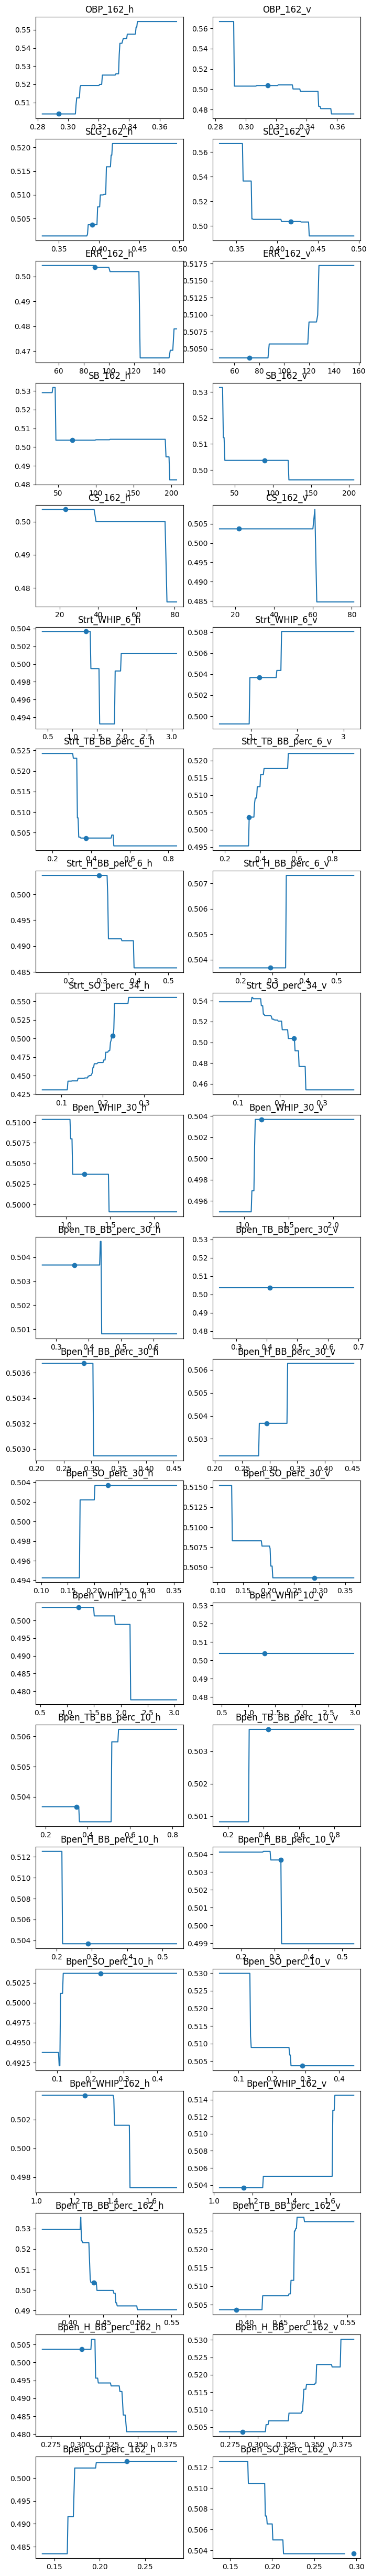

In [26]:
mli.ice_plot(d5['model'], plot_pts, features5, rd, plots_per_row=2)

In [27]:
df['SBadj_162_h'] = df['SB_162_h'] - 3*df['CS_162_h']
df['SBadj_162_v'] = df['SB_162_v'] - 3*df['CS_162_v']

In [28]:
df_train = df[(df.season>2000) & (df.season<=2015) & ~(df.OBP_162_h.isnull())]
df_valid = df[(df.season>=2016) & (df.season<=2020)]
df_test = df[df.season>=2021]
df_test_val = df[df.season>=2019]

In [29]:
len(df.OBP_162_h)

56765

In [30]:
features6  = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
             'ERR_162_h', 'ERR_162_v',
             # 'SB_162_h', 'SB_162_v',
             # 'CS_162_h', 'CS_162_v',
             'SBadj_162_h','SBadj_162_v',
             
            'Strt_WHIP_34_h','Strt_WHIP_34_v',
            'Strt_TB_BB_perc_34_h', 'Strt_TB_BB_perc_34_v',
            'Strt_H_BB_perc_34_h', 'Strt_H_BB_perc_34_v',
            'Strt_SO_perc_100_h', 'Strt_SO_perc_100_v',
            'Bpen_WHIP_30_h','Bpen_WHIP_30_v',
            'Bpen_TB_BB_perc_30_h', 'Bpen_TB_BB_perc_30_v',
            'Bpen_H_BB_perc_30_h', 'Bpen_H_BB_perc_30_v',
            'Bpen_SO_perc_30_h', 'Bpen_SO_perc_30_v',
            'Bpen_WHIP_10_h','Bpen_WHIP_10_v',
            'Bpen_TB_BB_perc_10_h', 'Bpen_TB_BB_perc_10_v',
            'Bpen_H_BB_perc_10_h', 'Bpen_H_BB_perc_10_v',
            'Bpen_SO_perc_10_h', 'Bpen_SO_perc_10_v',
            'Bpen_WHIP_162_h','Bpen_WHIP_162_v',
            'Bpen_TB_BB_perc_162_h', 'Bpen_TB_BB_perc_162_v',
            'Bpen_H_BB_perc_162_h', 'Bpen_H_BB_perc_162_v',
            'Bpen_SO_perc_162_h', 'Bpen_SO_perc_162_v',
            ]


In [31]:
d6 = try_features(features6)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[662]	valid_0's binary_logloss: 0.67777

Vegas probs: 0.6704071693200951 on test
model probs: 0.6770080825195087 on test

Difference: 0.006600913199413583 on test

Avg Shap Vals
Intercept                0.166947
Strt_SO_perc_100_v       0.070183
Strt_SO_perc_100_h       0.052963
SLG_162_h                0.047327
Strt_TB_BB_perc_34_h     0.042562
OBP_162_h                0.040905
Strt_H_BB_perc_34_h      0.039098
OBP_162_v                0.036920
Bpen_TB_BB_perc_162_v    0.033286
Strt_TB_BB_perc_34_v     0.030858
SLG_162_v                0.029389
Strt_WHIP_34_h           0.027324
Strt_H_BB_perc_34_v      0.026387
Strt_WHIP_34_v           0.024901
Bpen_TB_BB_perc_30_h     0.024835
Bpen_TB_BB_perc_162_h    0.023052
Bpen_H_BB_perc_162_v     0.022604
SBadj_162_h              0.019164
Bpen_H_BB_perc_162_h     0.018654
SBadj_162_v              0.017270
Bpen_SO_perc_30_v        0.015853
Bpen_SO_perc

Let's analyze model 3 (our best model so far)

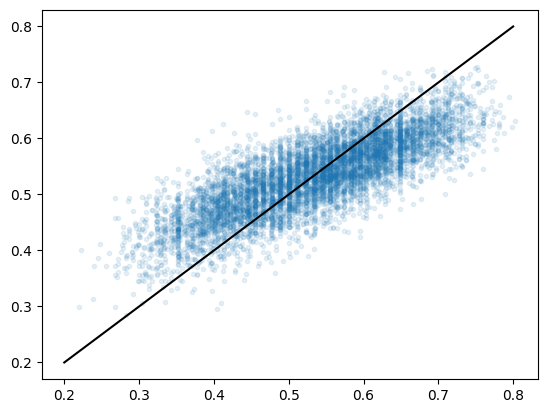

In [28]:
plt.scatter(df_test.implied_prob_h_mid, d3['preds_test'], marker='.', alpha=.1)
plt.plot([.2,.8],[.2,.8], color='k')

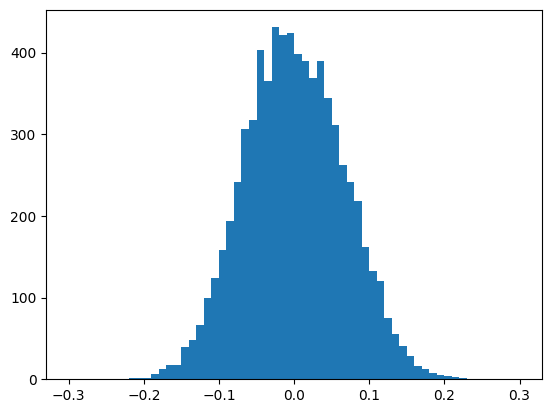

In [29]:
test_disc = d3['preds_test'] - df_test.implied_prob_h_mid
plt.hist(test_disc, bins=np.linspace(-.3,.3,61));

In [30]:
## let's compare performance on the cases with a large discrepancy
mask = (np.abs(test_disc))>.1
log_loss(y_test[mask], d3['preds_test'][mask]), log_loss(y_test[mask], df_test.implied_prob_h_mid[mask])

(0.6773505135363447, 0.6460670496102819)

In [31]:
log_loss(y_test[~mask], d3['preds_test'][~mask]), log_loss(y_test[~mask], df_test.implied_prob_h_mid[~mask])

(0.6792755363093299, 0.6739955063886707)

Conclusions
    - Still about 40 bps away from Vegas probabilities (down from ~70)
    - When our model and Vegas "disagree", Vegas is generally right!

    - We are running out of "big wins"
    - Features based on actual starting lineup
    - Fielding
    - Lefty vs Righty analysis

Next Steps

    - Get individual batter data
    - Make features based on the actual lineup
    - Analyze runs scored (over/under)
    - Perhaps the model for runs scored will help with the moneyline model